In [ ]:
#Import all the necessary Libraries
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import partial_dependence
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler


In [ ]:
# Read the dataset
data = pd.read_csv('/content/drive/MyDrive/performance_data.csv')

In [ ]:
# Define extraction functions for disk_io and net_io metrics
def extract_disk_io_metric(row, metric_name):
    pattern = re.compile(rf"{metric_name}_bytes=\d+")
    match = pattern.search(row['disk_io_counters'])
    return int(match.group().split("=")[1]) if match else 0

def extract_net_io_metric(row, metric_name):
    pattern = re.compile(rf"{metric_name}=[\d]+")
    match = pattern.search(row['net_io_counters'])
    return int(match.group().split("=")[1]) if match else 0

# Extract features and add new columns
data['disk_io_read_bytes'] = data.apply(lambda row: extract_disk_io_metric(row, "read"), axis=1)
data['disk_io_write_bytes'] = data.apply(lambda row: extract_disk_io_metric(row, "write"), axis=1)
data['net_io_bytes_sent'] = data.apply(lambda row: extract_net_io_metric(row, "bytes_sent"), axis=1)
data['net_io_bytes_recv'] = data.apply(lambda row: extract_net_io_metric(row, "bytes_recv"), axis=1)

# Drop the original columns
data = data.drop(columns=['disk_io_counters', 'net_io_counters','graphics_name','graphics_DeviceID'])
data

,cpu_percent,memory_percent,graphics_ram_size,completion_time,disk_io_read_bytes,disk_io_write_bytes,net_io_bytes_sent,net_io_bytes_recv
0,8.3,58.5,1.000000e+00,1.144151,7783643136,9940840448,25066440,283583047
1,71.7,63.0,1.000000e+00,2.730921,3507616256,336119296,944777,20161756
2,29.5,86.1,1.778275e+00,4.560630,27115557376,23783241216,497964930,10987785882
3,11.5,89.3,1.073742e+09,1.322939,170033679360,51831967744,45297907,327518128
4,7.8,87.9,1.000000e+00,3.052404,14975958016,6321999872,9848370,149783862
5,6.5,65.3,1.000000e+00,1.163546,415506500096,169426402304,11810117,147029537
6,15.5,92.6,1.000000e+00,1.297943,126897055232,50302754304,127672686,401643237
7,1.9,76.0,5.000000e-01,1.171459,8685346816,6458343936,28152392,518630909
8,0.8,76.2,5.000000e-01,1.154448,8723618816,6595331584,28789701,523642835
9,0.4,82.0,5.000000e-01,1.204547,8722670080,6519408128,28779765,523632898


In [ ]:
# Feature scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(data[['cpu_percent', 'memory_percent', 'disk_io_read_bytes', 'disk_io_write_bytes', 'net_io_bytes_sent', 'net_io_bytes_recv', 'graphics_ram_size']])

#X = scaler.fit_transform(data.drop(columns=['completion_time']))
y = data['completion_time']


In [ ]:
# Convert scaled features (X) to a DataFrame
X_df = pd.DataFrame(X, columns=['cpu_percent', 'memory_percent', 'disk_io_read_bytes', 'disk_io_write_bytes', 'net_io_bytes_sent', 'net_io_bytes_recv', 'graphics_ram_size'])
data = pd.concat([X_df,y],axis=1)
data

,cpu_percent,memory_percent,disk_io_read_bytes,disk_io_write_bytes,net_io_bytes_sent,net_io_bytes_recv,graphics_ram_size,completion_time
0,0.090909,0.285444,0.005999,0.050461,0.048533,0.024018,2.793968e-09,1.144151
1,0.793792,0.370510,0.000000,0.000000,0.000000,0.000000,2.793968e-09,2.730921
2,0.325942,0.807183,0.033118,0.123185,1.000000,1.000000,3.518792e-09,4.560630
3,0.126386,0.867675,0.233610,0.270547,0.089238,0.028024,1.000000e+00,1.322939
4,0.085366,0.841210,0.016088,0.031448,0.017914,0.011819,2.793968e-09,3.052404
5,0.070953,0.413989,0.577971,0.888359,0.021861,0.011567,2.793968e-09,1.163546
6,0.170732,0.930057,0.173096,0.262513,0.254975,0.034783,2.793968e-09,1.297943
7,0.019956,0.616257,0.007264,0.032165,0.054741,0.045449,2.328306e-09,1.171459
8,0.007761,0.620038,0.007317,0.032884,0.056024,0.045906,2.328306e-09,1.154448
9,0.003326,0.729679,0.007316,0.032486,0.056004,0.045905,2.328306e-09,1.204547


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Instantiate the Random Forest Regressor model

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1)
# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance using R-squared
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R-squared:", r2_rf)


Random Forest R-squared: 0.7287859297735215


In [ ]:
feature_importances = rf_model.feature_importances_
feature_names = list(data.columns)[:-1]  # Exclude dependent variable column

# Print feature importance
for name, importance in zip(feature_names, feature_importances):
    print(f"Feature: {name}, Importance: {importance:.2f}")


Feature: cpu_percent, Importance: 0.05
Feature: memory_percent, Importance: 0.04
Feature: disk_io_read_bytes, Importance: 0.01
Feature: disk_io_write_bytes, Importance: 0.12
Feature: net_io_bytes_sent, Importance: 0.42
Feature: net_io_bytes_recv, Importance: 0.35
Feature: graphics_ram_size, Importance: 0.00


In [ ]:
# Create a DataFrame to store the feature importance scores
importance_df = pd.DataFrame(importance_matrix.importances_mean, index=feature_cols, columns=['Importance'])

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

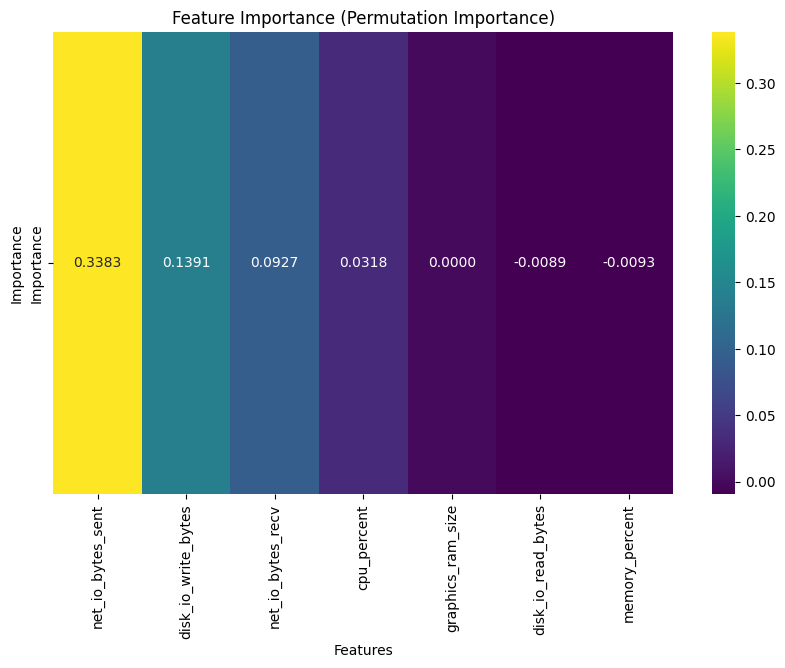

In [ ]:
# Plot the feature importance heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(importance_df.transpose(), cmap='viridis', annot=True, fmt=".4f")
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
